# Titanic Kaggle Competition

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
from ipywidgets import interact

In [2]:
train_data = pd.read_csv("titanic_datasets/train.csv")
test_data = pd.read_csv("titanic_datasets/test.csv")
gender_data = pd.read_csv("titanic_datasets/gender_submission.csv")

### Exploring a Pattern

In [3]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)



% of women who survived: 0.7420382165605095


In [4]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


### Joining DataFrames for Test Dataset

In [5]:
test_data = pd.merge(test_data,gender_data)      #small data pipeline   #have survived variable in test_data 

test_data.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


### Missing Value Imputation

In [6]:
nan_counts = train_data.isna().sum().sort_values(ascending = False)
summary = pd.concat([train_data.info(), nan_counts], axis=0)
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


In [7]:
nan_counts = test_data.isna().sum().sort_values(ascending = False)
summary = pd.concat([train_data.info(), nan_counts], axis=0)
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
Survived         0
dtype: int64


### Data Preprocessing Steps

Map sex to is_male, to use variable in the correlation plots, and ML models

Map embarqued to embarqued_code {1,2,3}. Reserve the zero, for NaN values (missing value imputation for unknown variables)

Split variable ticket to ticket preffix, and ticket n

Group the duplication ticket values, count number of people that traveled together, including friends, maids, and nannies. Create variable "companions"

Create variable "family size", by combining the number of sibling (sibsp), and parents and children (parch) (feature engineering)

Extract variable "title", from the variable name, and categorise.

Map "fare", to "fare_level", where each level is mapped in ordered ordinal encoding. This means that each category is encoded into mapping into a number.

Split cabin into cabin level, cabin n, and n of cabins

Map variable "age" into age group

In [8]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
train_data = train_data.drop(['Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Name', 'PassengerId'], axis=1)

In [10]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,3,female,47.0,1,0,363272,7.0000,NaN,S,1
2,2,male,62.0,0,0,240276,9.6875,NaN,Q,0
3,3,male,27.0,0,0,315154,8.6625,NaN,S,0
4,3,female,22.0,1,1,3101298,12.2875,NaN,S,1


In [12]:
# Mapping Sex bolean
train_data['Is_male'] = train_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_data['Is_male'] = test_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [13]:
train_data = train_data.drop('Sex', axis=1)
test_data = test_data.drop('Sex', axis=1)

### Checking for Missing Values

### Replacing Median Value for Embarked

In [14]:
# Check the entries with NaN vales.
train_data.loc[train_data['Embarked'].isna(),:]

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_male
61,1,1,38.0,0,0,113572,80.0,B28,NaN,0
829,1,1,62.0,0,0,113572,80.0,B28,NaN,0


In [15]:
# Fill the NaN and map Embarked to numerical codes
train_data.loc[train_data['Embarked'].isna(), 'Embarked'] = 'S'  # (Encyclopedia titanica)
train_data['Embarked_code'] = train_data['Embarked'].map( {'C': 1, 'Q': 2, 'S': 3} ).astype(int)

train_data['Embarked_code']

0      3
1      1
2      3
3      3
4      3
      ..
886    3
887    3
888    3
889    1
890    2
Name: Embarked_code, Length: 891, dtype: int32

In [16]:
# Fill the NaN and map Embarked to numerical codes
test_data.loc[train_data['Embarked'].isna(), 'Embarked'] = 'S'  # (Encyclopedia titanica)
test_data['Embarked_code'] = test_data['Embarked'].map( {'C': 1, 'Q': 2, 'S': 3} ).astype(int)

test_data['Embarked_code']

0      2
1      3
2      2
3      3
4      3
      ..
413    3
414    1
415    3
416    3
417    1
Name: Embarked_code, Length: 418, dtype: int32

In [17]:
train_data = train_data.drop('Embarked', axis=1)
test_data = test_data.drop('Embarked', axis=1)

### Replacing Median Value for Age

In [18]:
# Calculate the median age
median_age = train_data['Age'].median()

# Impute missing values with the median age
train_data['Age'].fillna(median_age, inplace=True)

# Verify if there are no missing values left
print("Number of missing values in 'Age' column after imputation:", train_data['Age'].isnull().sum())

Number of missing values in 'Age' column after imputation: 0


In [19]:
# Calculate the median age
median_age = test_data['Age'].median()

# Impute missing values with the median age
test_data['Age'].fillna(median_age, inplace=True)

# Verify if there are no missing values left
print("Number of missing values in 'Age' column after imputation:", test_data['Age'].isnull().sum())

Number of missing values in 'Age' column after imputation: 0


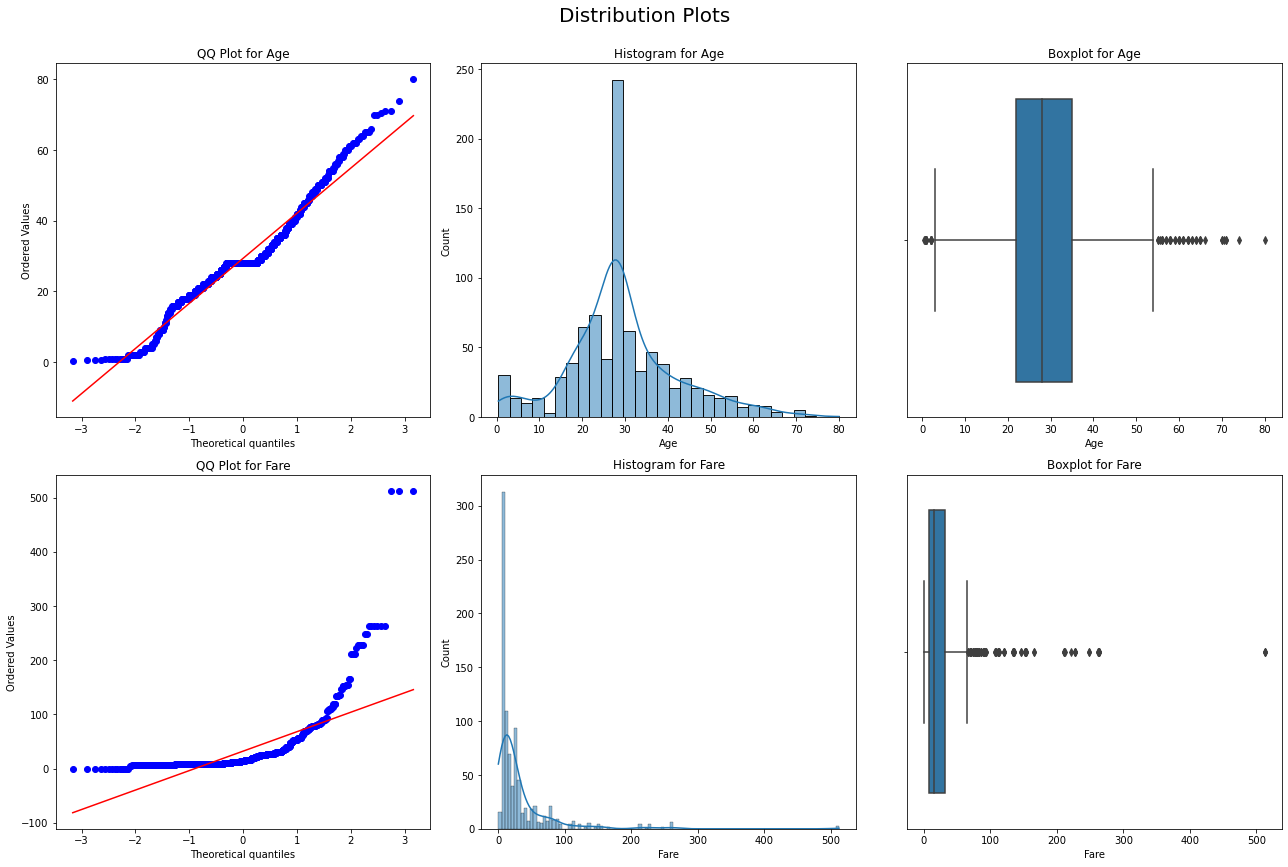

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_distribution(data, columns, suptitle="", suptitle_y=1):
    num_cols = len(columns)
    fig, axs = plt.subplots(num_cols, 3, figsize=(18, 6*num_cols))
    plt.suptitle(suptitle, fontsize=20, y=suptitle_y)  # Add super title
    
    for i, col in enumerate(columns):
        # QQ plot
        stats.probplot(data[col], dist="norm", plot=axs[i, 0])
        axs[i, 0].set_title(f'QQ Plot for {col}')
        
        # Histogram
        sns.histplot(data[col], kde=True, ax=axs[i, 1])
        axs[i, 1].set_title(f'Histogram for {col}')
        
        # Boxplot
        sns.boxplot(x=data[col], ax=axs[i, 2])
        axs[i, 2].set_title(f'Boxplot for {col}')
        
    plt.tight_layout()
    plt.show()

# Usage example with custom suptitle
plot_distribution(train_data, ['Age', 'Fare'], suptitle="Distribution Plots")


### Replacing Median Value for Fare

In [21]:
# Calculate the median age
median_age = train_data['Fare'].median()

# Impute missing values with the median age
train_data['Fare'].fillna(median_age, inplace=True)

# Verify if there are no missing values left
print("Number of missing values in 'Age' column after imputation:", train_data['Fare'].isnull().sum())

Number of missing values in 'Age' column after imputation: 0


In [22]:
# Calculate the median age
median_age = test_data['Fare'].median()

# Impute missing values with the median age
test_data['Fare'].fillna(median_age, inplace=True)

# Verify if there are no missing values left
print("Number of missing values in 'Age' column after imputation:", test_data['Fare'].isnull().sum())

Number of missing values in 'Age' column after imputation: 0


### Replacing Outliers using Winsorisation

In [23]:
def replace_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data[col] = data[col].apply(lambda x: x if lower_bound <= x <= upper_bound else 1.5 * IQR)
    return data

# List of columns to replace outliers
columns_to_replace_outliers = ['Age', 'Fare']  # Add more columns as needed

# Replace outliers with 1.5 times IQR
train_data_cleaned = replace_outliers_iqr(train_data.copy(), columns_to_replace_outliers)


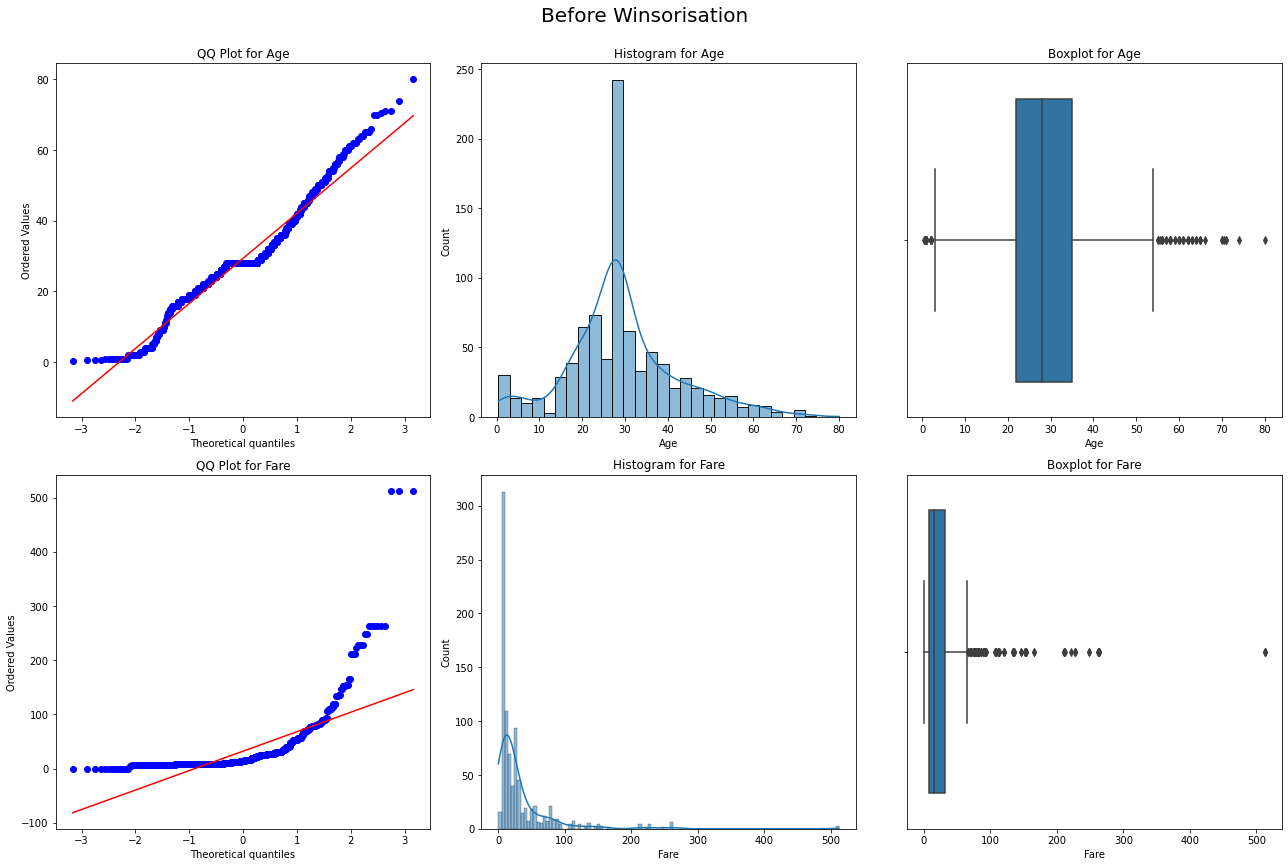

In [24]:
# Plot distribution before and after replacing outliers
plot_distribution(train_data, columns_to_replace_outliers, suptitle='Before Winsorisation')

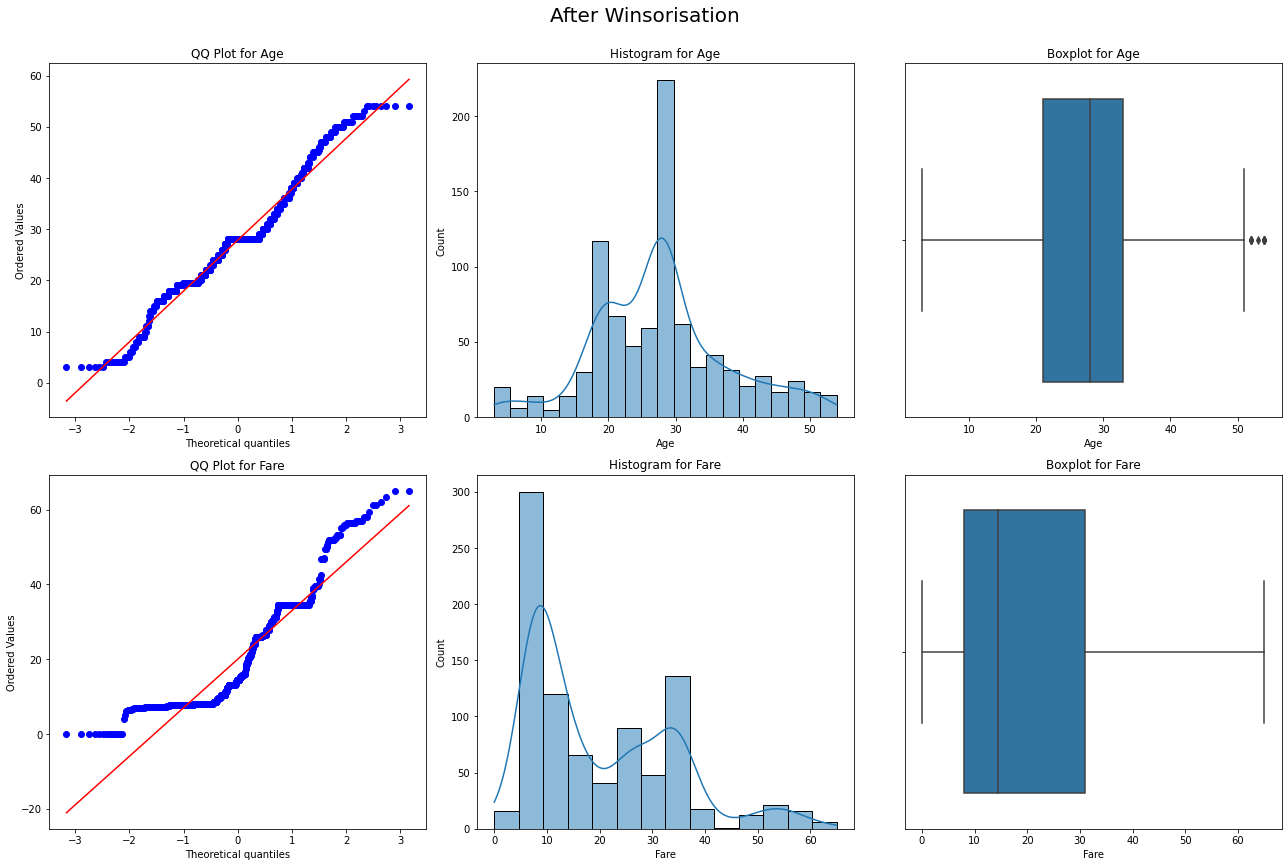

In [25]:
plot_distribution(train_data_cleaned, columns_to_replace_outliers, suptitle='After Winsorisation')

In [26]:
train_data

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Is_male,Embarked_code
0,0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,3
1,1,1,38.0,1,0,PC 17599,71.2833,C85,0,1
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,3
3,1,1,35.0,1,0,113803,53.1000,C123,0,3
4,0,3,35.0,0,0,373450,8.0500,NaN,1,3
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,211536,13.0000,NaN,1,3
887,1,1,19.0,0,0,112053,30.0000,B42,0,3
888,0,3,28.0,1,2,W./C. 6607,23.4500,NaN,0,3
889,1,1,26.0,0,0,111369,30.0000,C148,1,1


In [27]:
test_data

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived,Is_male,Embarked_code
0,3,34.5,0,0,330911,7.8292,NaN,0,1,2
1,3,47.0,1,0,363272,7.0000,NaN,1,0,3
2,2,62.0,0,0,240276,9.6875,NaN,0,1,2
3,3,27.0,0,0,315154,8.6625,NaN,0,1,3
4,3,22.0,1,1,3101298,12.2875,NaN,1,0,3
...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,A.5. 3236,8.0500,NaN,0,1,3
414,1,39.0,0,0,PC 17758,108.9000,C105,1,0,1
415,3,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,1,3
416,3,27.0,0,0,359309,8.0500,NaN,0,1,3


Hence the embarked code is mapped into numbers

### Temporarily Dropping Additional Variables

In [28]:
train_data = train_data.drop('Ticket', axis=1)
test_data = test_data.drop('Ticket', axis=1)

In [29]:
train_data.isnull().sum()

Survived           0
Pclass             0
Age                0
SibSp              0
Parch              0
Fare               0
Cabin            687
Is_male            0
Embarked_code      0
dtype: int64

Since cabin variable has the most missing values, we drop that variable temporarily

In [30]:
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

### Applying Data Transformation

In [31]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

# List of numerical variables (excluding 'Survived' assuming it's the target variable)
numerical_vars = ['Age', 'Fare']

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

In [32]:
# Fit the transformer on the training data and transform it
train_data[numerical_vars] = pt.fit_transform(train_data[['Age', 'Fare']])
# Fit the transformer on the training data and transform it
test_data[numerical_vars] = pt.fit_transform(test_data[['Age', 'Fare']])

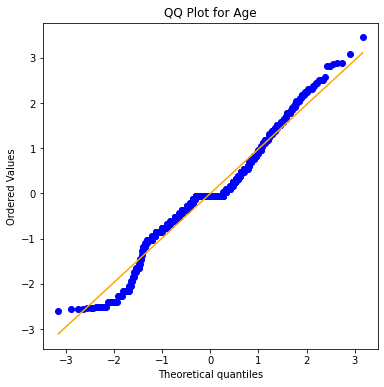

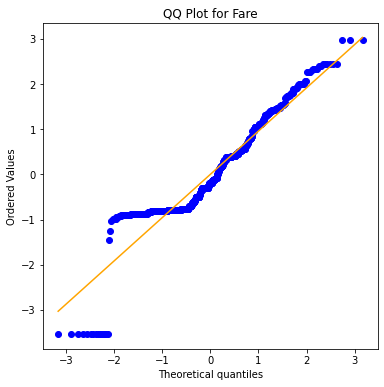

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your transformed dataset is stored in train_data after applying Yeo-Johnson transformation

# List of numerical variables (excluding 'Survived' assuming it's the target variable)
numerical_vars = ['Age', 'Fare']

# Create QQ plots for each transformed numerical variable
for var in numerical_vars:
    # Generate QQ plot
    fig, ax = plt.subplots(figsize=(6, 6))
    stats.probplot(train_data[var], dist="norm", plot=ax)
    ax.set_title(f'QQ Plot for {var}')
    ax.get_lines()[1].set_color('orange')  # Set color for the line of best fit (optional)
    plt.show()

### Scaling the Data

In [34]:
# Initialize the StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

In [35]:
train_data_scaled = train_data
test_data_scaled = test_data

<AxesSubplot:>

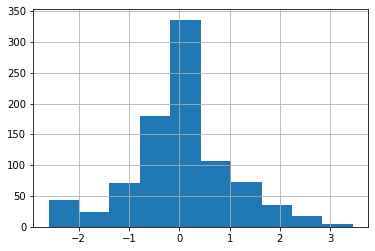

In [36]:
train_data_scaled['Age'].hist()

In [37]:
# Fit the scaler on the transformed training data and transform it
train_data_scaled[numerical_vars] = scaler.fit_transform(train_data[numerical_vars])
# Fit the scaler on the transformed training data and transform it
test_data_scaled[numerical_vars] = scaler.fit_transform(test_data[numerical_vars])

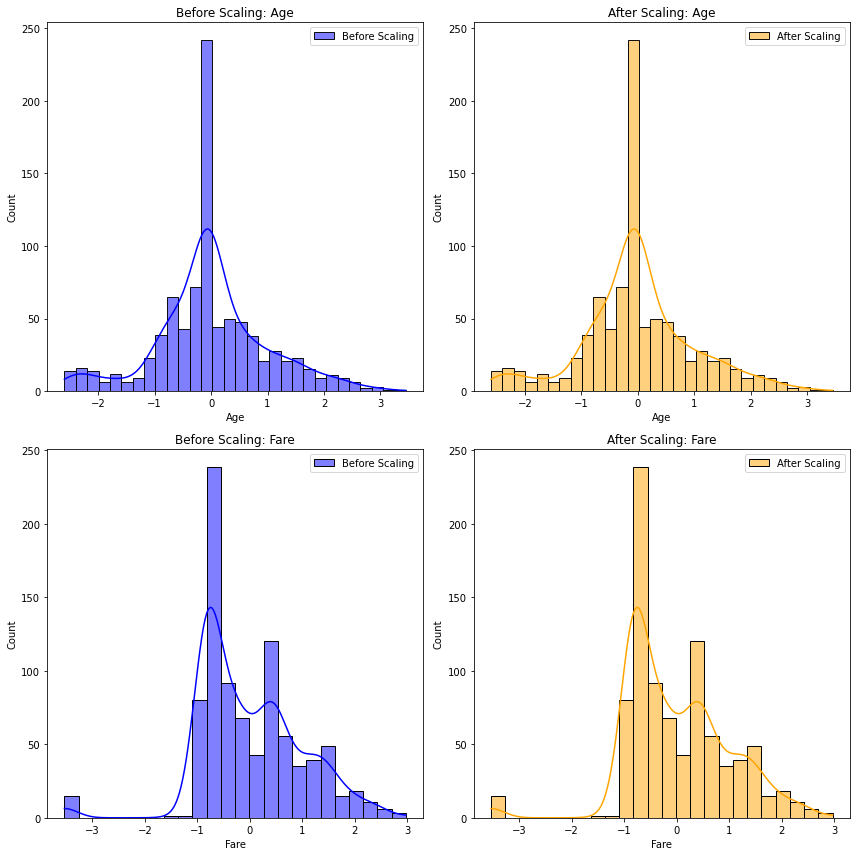

In [38]:
def plot_before_after_scaling(train_data_before, train_data_after, numerical_vars):
    num_cols = len(numerical_vars)
    fig, axs = plt.subplots(num_cols, 2, figsize=(12, 6*num_cols))
    
    for i, col in enumerate(numerical_vars):
        # Before scaling
        sns.histplot(train_data_before[col], kde=True, ax=axs[i, 0], color='blue', label='Before Scaling')
        axs[i, 0].set_title(f'Before Scaling: {col}')
        axs[i, 0].legend()
        
        # After scaling
        sns.histplot(train_data_after[col], kde=True, ax=axs[i, 1], color='orange', label='After Scaling')
        axs[i, 1].set_title(f'After Scaling: {col}')
        axs[i, 1].legend()
        
    plt.tight_layout()
    plt.show()

# Usage example
plot_before_after_scaling(train_data, train_data_scaled, numerical_vars)

### Seeing Correlation of Target Variable against other Variables

In [39]:
train_data['Survived'].corr(train_data['Age'])
#=> -0.07722109457217768
#=> -7.72%

-0.07431964428148158

### Using Pearson Correlation Coefficient

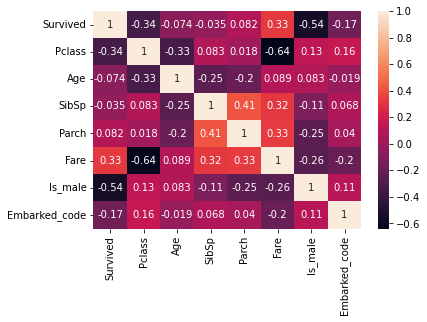

In [40]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(train_data.corr(), annot=True)
plt.show()

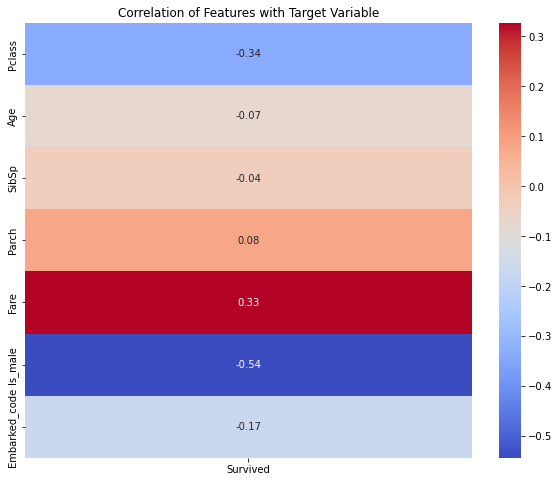

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = train_data.corr()

# Get correlation of features with the target variable
target_correlation = corr_matrix['Survived'].drop('Survived')  # Assuming the target variable is 'Survived'

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with Target Variable')
plt.show()


### Using Cramér's V to Measure Association between 2 Nominal Variables

In [42]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(train_data['Is_male'], train_data['Survived'])
cramers_v_score = cramers_v(confusion_matrix)

print("Cramér's V Score for Is_male:", cramers_v_score)


Cramér's V Score for Is_male: 0.5401999468101071


### Using $\phi$ (Phi) Coefficient

To compare between two binary variables, analysing its correlation strength in terms of $\phi$

### Proofs
The Phi coefficient is a measure of association between two binary variables. It ranges from -1 to 1, where:

- 1 indicates a perfect positive association (both variables agree perfectly)
- 0 indicates no association between the variables
- -1 indicates a perfect negative association (variables disagree perfectly)

$$\phi = \frac{(ad−bc)}{(a+b)(c+d)(a+c)(b+d)}$$

where:


a, b, c, and d are counts of observations falling into each of the four categories formed by the combinations of the two binary variables.

### How to Derive a, b, c, and d?

- a: Count of observations where both Variable 1 and Variable 2 are 1.
- b: Count of observations where Variable 1 is 1 and Variable 2 is 0.
- c: Count of observations where Variable 1 is 0 and Variable 2 is 1.
- d: Count of observations where both Variable 1 and Variable 2 are 0.

### Construct Contingency Table
First, construct a 2x2 contingency table (also known as a frequency table) with counts for each combination of values of the two binary variables. The table looks like this:

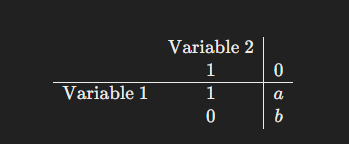

Then, a, b, c, and d are used to calculate the $\phi$ coefficient.

In [43]:
!pip install phik

In [44]:
import phik

# 'Survived' is the target variable and 'Sex' is another binary variable in your DataFrame
phi_coefficient = train_data.phik_matrix()['Survived']['Is_male']

print("Phi Coefficient (φ) between 'Survived' and 'Sex':", phi_coefficient)

interval columns not set, guessing: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Is_male', 'Embarked_code']
Phi Coefficient (φ) between 'Survived' and 'Sex': 0.7503215961090612


In [45]:
import phik

# Assuming 'Survived' is the target variable
target_variable = 'Survived'

# Get all binary variables (excluding the target variable)
binary_variables = [col for col in train_data.columns if train_data[col].nunique() == 2 and col != target_variable]

# Calculate Phi coefficients for each binary variable
phi_coefficients = {}
for binary_var in binary_variables:
    phi_coefficient = train_data.phik_matrix()[target_variable][binary_var]
    phi_coefficients[binary_var] = phi_coefficient

# Display Phi coefficients for each binary variable
for binary_var, phi_coefficient in phi_coefficients.items():
    print(f"Phi Coefficient (φ) between '{target_variable}' and '{binary_var}': {phi_coefficient}")


interval columns not set, guessing: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Is_male', 'Embarked_code']
Phi Coefficient (φ) between 'Survived' and 'Is_male': 0.7503215961090612


In [46]:
train_data.isnull().sum()

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Is_male          0
Embarked_code    0
dtype: int64

In [47]:
test_data.isnull().sum()

Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Survived         0
Is_male          0
Embarked_code    0
dtype: int64

In [48]:
from scipy.stats import pointbiserialr, pearsonr

# Assuming 'Survived' is the binary target variable
target_variable = 'Survived'

# Get all numeric variables (excluding the target variable)
numeric_variables = [col for col in train_data.columns if train_data[col].dtype == 'float64' or train_data[col].dtype == 'int64']

# Calculate correlation for each numeric variable
for numeric_var in numeric_variables:
    if train_data[numeric_var].nunique() == 2:
        # Calculate Phi coefficient for binary variables
        phi_coefficient, p_value = pointbiserialr(train_data[numeric_var], train_data[target_variable])
        print(f"Phi Coefficient (φ) between '{numeric_var}' and '{target_variable}':", phi_coefficient)
        print("p-value:", p_value)
    else:
        # Calculate Pearson correlation coefficient for continuous variables
        pearson_corr, p_value = pearsonr(train_data[numeric_var], train_data[target_variable])
        print(f"Pearson Correlation Coefficient between '{numeric_var}' and '{target_variable}':", pearson_corr)
        print("p-value:", p_value)


Phi Coefficient (φ) between 'Survived' and 'Survived': 1.0
p-value: 0.0
Pearson Correlation Coefficient between 'Pclass' and 'Survived': -0.33848103596101514
p-value: 2.5370473879814938e-25
Pearson Correlation Coefficient between 'Age' and 'Survived': -0.07431964428148162
p-value: 0.026529779479276722
Pearson Correlation Coefficient between 'SibSp' and 'Survived': -0.035322498885735625
p-value: 0.29224392869829086
Pearson Correlation Coefficient between 'Parch' and 'Survived': 0.08162940708348349
p-value: 0.014799245374727947
Pearson Correlation Coefficient between 'Fare' and 'Survived': 0.3269143942075409
p-value: 1.2299060075834304e-23


In [49]:
# # split the column 'Ticket'
# Ticket_split = []
# Ticket_len = []
# for i in train_data['Ticket'].index:
#     splitted = train_data.loc[i,'Ticket'].split(' ')
#     Ticket_split.append(splitted)
#     length = len(splitted)
#     Ticket_len.append(length)

# train_data['Ticket_split'] = Ticket_split
# train_data['Ticket_len'] = Ticket_len  

In [50]:
# # df[['Ticket_len']].value_counts()
# # df.loc[df['Ticket_len'] > 2, :] We can see tome typo errors.

# # Create columns Ticket_preffix and Ticket_number
# ticket_preffix = []
# ticket_number = []
# for i in train_data['Ticket'].index:
#     ticket_parts = train_data.loc[i, 'Ticket_split']
#     number = ticket_parts[-1]
#     ticket_number.append(number)
#     length = train_data.loc[i, 'Ticket_len'].item()
#     if length > 1:
#         preffix = ''.join(ticket_parts[0:-1])
#         ticket_preffix.append(preffix)
#     else:
#         ticket_preffix.append('blank')

In [51]:
# train_data['Ticket_preffix'] = ticket_preffix
# train_data['Ticket_number'] = ticket_number
# # drop unnecessary columns created
# train_data.drop(columns=['Ticket_split', 'Ticket_len'], inplace=True)

# train_data.Ticket_preffix.unique()

In [52]:
# df_grouped = train_data.groupby(['Ticket_preffix', 'Embarked']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
# df_grouped.columns = ['Survived', 'Non-Survived']
# df_grouped['Count'] = train_data.groupby(['Ticket_preffix', 'Embarked']).size()
# df_grouped

We extract implicit info, from duplicated values in the variable ticket. We create a new var to describe it, by engineering a new variable companions

In [53]:
# n_alone , n_duplicates = train_data['Ticket'].duplicated(keep=False).astype(int).value_counts()
# print("Number of duplicated ticket values:", n_duplicates)
# print("Number of non-duplicated ticket values:", n_alone)

In [54]:
# train_data['Companions'] = train_data['Ticket'].duplicated(keep=False).astype(int) * train_data.groupby('Ticket')['Ticket'].transform('count') -1 
# train_data.loc[train_data['Companions'] == -1, 'Companions'] = 0

In [55]:
# train_data['Companions'].value_counts()

In [56]:
# train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
# print(train_data[['SibSp','Parch','FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by = 'Survived'))

In [57]:
# train_data['Title'] = train_data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
#   'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'noble')
# train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
# train_data['Title'] = train_data['Title'].replace('Ms', 'Mrs')
# train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

In [58]:
# # Check the survival rate for the title cathegories obtained
# df_grouped = train_data.groupby(['Title', 'Sex']).agg({'Survived': ['sum', lambda x: x.count() - x.sum()]})
# df_grouped.columns = ['Survived', 'Non-Survived']
# df_grouped['Count'] = train_data.groupby(['Title', 'Sex']).size()
# # Calculate the survived/non-survived rate
# df_grouped['Survival Rate'] = df_grouped['Survived'] / (df_grouped['Survived'] + df_grouped['Non-Survived'])
# # Order the DataFrame by the survival rate in descending order
# df_grouped = df_grouped.sort_values('Survival Rate', ascending=False)

# print(df_grouped)

In [59]:
# train_data['noble'] = train_data['Title'].apply(lambda x: 1  if x =='noble'  else 0)
# train_data['noble'].value_counts()

In [60]:
# # fill with the median Fare for the Pclass = 3 and Sex= male.
# Fare_Pclass3_male = train_data.loc[(train_data['Pclass'] == 3) & (train_data['Sex'] == 'male'), 'Fare'].median()
# train_data.loc[train_data['PassengerId'] == 1044, 'Fare'] = train_data.loc[(train_data['Pclass'] == 3) & (train_data['Sex'] == 'male'), 'Fare'].median()
# print("medium Fare for Sex = male and Pclass=3: ", Fare_Pclass3_male)

In [61]:
# # Divide Fare in 10 levels
# n = 10
# train_data['Fare_level'] = pd.cut(train_data['Fare'], n, labels=np.arange(1,n+1))
# train_data['Fare_range'] = pd.cut(train_data['Fare'], n)

In [62]:
# # Calculate survival probability for each fare level
# fare_survival_grouped = train_data.groupby('Fare_level').agg({'Fare_range': ['first', 'count'], 'Survived': 'mean'}).reset_index()
# fare_survival_grouped.columns = ['Fare_level', 'Fare_range', 'Count', 'Survival_proba']
# fare_survival_grouped = fare_survival_grouped.reset_index(drop=True)
# fare_survival_grouped

In [63]:
# train_data.head()

### Naïve Baseline Model

In [64]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Compute the mode of the 'Survived' column
mode_prediction = train_data_cleaned['Survived'].mode()[0]

# Create predictions by replicating the mode value for the length of the dataset
predictions = [mode_prediction] * len(train_data_cleaned['Survived'])

# Calculate accuracy by comparing predictions with the actual 'Survived' values
accuracy = accuracy_score(train_data_cleaned['Survived'], predictions)

print("Naive Baseline Accuracy:", accuracy)


Naive Baseline Accuracy: 0.6161616161616161


In [65]:
train_data_scaled

,Survived,Pclass,Age,SibSp,Parch,Fare,Is_male,Embarked_code
0,0,3,-0.523388,1,0,-0.878820,1,3
1,1,1,0.685109,1,0,1.336651,0,1
2,1,3,-0.208093,0,0,-0.790065,0,3
3,1,1,0.468033,1,0,1.067352,0,3
4,0,3,0.468033,0,0,-0.774439,1,3
...,...,...,...,...,...,...,...,...
886,0,2,-0.130855,0,0,-0.294907,1,3
887,1,1,-0.767474,0,0,0.527906,0,3
888,0,3,-0.054196,1,2,0.288885,0,3
889,1,1,-0.208093,0,0,0.527906,1,1


In [66]:
test_data_scaled

,Pclass,Age,SibSp,Parch,Fare,Survived,Is_male,Embarked_code
0,3,0.432975,0,0,-0.903049,0,1,2
1,3,1.330008,1,0,-1.042542,1,0,3
2,2,2.327412,0,0,-0.643707,0,1,2
3,3,-0.145793,0,0,-0.778850,0,1,3
4,3,-0.554798,1,1,-0.364663,1,0,3
...,...,...,...,...,...,...,...,...
413,3,-0.145793,0,0,-0.868718,0,1,3
414,1,0.764354,0,0,1.611158,1,0,1
415,3,0.728046,0,0,-0.998599,0,1,3
416,3,-0.145793,0,0,-0.868718,0,1,3


In [67]:
train_data_cleaned

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Is_male,Embarked_code
0,0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,3
1,1,1,38.0,1,0,PC 17599,34.6344,C85,0,1
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,3
3,1,1,35.0,1,0,113803,53.1000,C123,0,3
4,0,3,35.0,0,0,373450,8.0500,NaN,1,3
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,211536,13.0000,NaN,1,3
887,1,1,19.0,0,0,112053,30.0000,B42,0,3
888,0,3,28.0,1,2,W./C. 6607,23.4500,NaN,0,3
889,1,1,26.0,0,0,111369,30.0000,C148,1,1


In [68]:
train_data_features = train_data_scaled.drop(['Survived'], axis=1)
test_data_features = test_data_scaled.drop(['Survived'], axis=1)

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define features and target variable
#features = ['Pclass', 'Is_male', 'Age']
target = 'Survived'

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data_scaled, train_data_scaled[target], test_size=0.2, random_state=42)

# Build a simple logistic regression model
model = make_pipeline(StandardScaler(), LogisticRegression())

# Train the model
model.fit(train_data_features, train_data_scaled['Survived'])

# Make predictions on the test set
y_pred = model.predict(test_data_features)

# Evaluate the model
accuracy = accuracy_score(test_data_scaled['Survived'], y_pred)
print("Accuracy of the baseline model:", accuracy)

Accuracy of the baseline model: 0.930622009569378
